# End-to-End Recomendation Machine with Explicit Feedback Data Example

This example shows how to perform training and inference with SageMaker's built-in Recomendation Machine algorithm. We will build a Movie Recommendation System using the MovieLens dataset ([F. Maxwell Harper and Joseph A. Konstan. 2015. The MovieLens Datasets: History and Context. ACM Transactions on Interactive Intelligent Systems (TiiS) 5, 4: 19:1–19:19.](https://dl.acm.org/doi/10.1145/2827872) .

The method we will use is a Factorization Machine classifier. Factorization Machine is a general-purpose supervised learning algorithm that you can use for classification and regression tasks. It is an extension of a linear model that is designed to parsimoniously capture interactions between features in high-dimensional sparse data sets. For example, in a click prediction system, the Factorization Machine model can capture observed click rate patterns. Factoring machines are a good choice for tasks related to high-dimensional sparse data sets, such as click prediction and item recommendation.

The Amazon SageMaker Factorization Machine algorithm provides a robust and highly scalable implementation of this algorithm, which has become extremely popular in ad click prediction and recommendation systems.

1. [Introduction](#Introduction)
2. [Prequisites and Preprocessing](#Prequisites-and-Preprocessing)
    * [Import Library](#Library)
    * [Permissions and environment variables](#Permissions-and-environment-variables)
    * [Data inspection](#Data-inspection)
    * [Exploratory data analysis](#Exploratory-data-analysis)
    * [Preprocessing of the data](#Preprocessing-data)
    * [Upload training data](#Upload-training-data)
2. [Training the model](#Training-model)
    * [Training parameters](#Training-parameters)
    * [Launch the Training job](#Training-job)
3. [Perform Batch Inference](#Batch-Inference)
4. [Perform Real-Time Inference](#Real-Time-Inference)
    * [Inferences](#Inferences)
    * [Recommend function](#Recommend)
5. [Cleanup](#Clean)

## Introduction 

The method that we’ll use is a factorization machine classifier. A factorization machine is a general-purpose supervised learning algorithm that you can use for both classification and regression tasks. It is an extension of a linear model that is designed to parsimoniously capture interactions between features in high dimensional sparse datasets.

Amazon SageMaker’s Factorization Machine algorithm provides a robust, highly scalable implementation of this algorithm, which has become extremely popular in ad click prediction and recommender systems.

FM is formulated as a linear model, with interactions between features as additional parameters (features). These feature interactions are done in their latent space representation instead of their plain format. It is represented mathematically as such:


<img src="https://cdn-images-1.medium.com/max/1200/0*vn90rfHHb5yPaZmo" width="60%" align="center" />

As mentioned, we can decompose the above equation into two parts — a Linear Regression model on the left-hand side and an equivalent matrix factorization on the right-hand side.

To understand it more easily, let’s take a look at how we can represent the user-item matrix we saw in MF.

<img src="https://cdn-images-1.medium.com/max/1200/1*LIUoxYjroygCiS5UhrMk4w.png" width="60%" align="center" />

For a start, we want to represent the user-item interaction as a one-hot encoding vector, where each row of the transformed will only have a single active user and item. We can then add in auxiliary features (e.g. other movies the user has rated, last movie rated, time he consumed that movie, etc) either as one-hot encodings or normalized vectors.

Broadly speaking, factorization machines are able to estimate interactions in sparse settings because they break the independence of the interaction parameters by factorizing them (using latent vectors as expressed in <v_i, v_j>). This means that data for one interaction helps also to estimate the parameters for related interactions (similar to the idea of matrix factorization and collaborative filtering).

To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on.!

<a id='Prequisites-and-Preprocessing'></a>

## Prequisites and Preprocessing
---
This notebook was tested in Amazon SageMaker Studio on a ml.t3.medium instance with Python 3 (Data Science) kernel.

<a id='Library'></a>
### Import Library



In [1]:
# librerias básicas
import re
import pandas as pd
import json
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from decimal import *
import pprint

# visualización
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(rc={'figure.figsize':(10,7)})

#matrices sparse
from scipy.sparse import lil_matrix

# Librerias para Amazon sagemaker
import boto3
import sagemaker
from sagemaker import get_execution_role

import io
import sagemaker.amazon.common as smac

from sagemaker.tuner import HyperparameterTuner
from sagemaker.tuner import IntegerParameter, ContinuousParameter

from sagemaker.deserializers import JSONDeserializer
from sagemaker.serializers import JSONSerializer


<a id='Permissions-and-environment-variables'></a>

### Permissions and environment variables

Let’s start by specifying:

   + The S3 buckets and prefixes that you want to use for training and model data and where the original data is located.

   + The IAM role arn used to give training and hosting access to your data.


In [2]:
role = get_execution_role()

sess = sagemaker.Session()
bucket = sess.default_bucket()
prefix = "builtin-notebooks/Recomendation-Machine/Explicit"
print(f"role: {role} bucket: {bucket}")

train_key = 'train.protobuf'
train_prefix = '{}/{}'.format(prefix, 'train')
s3_train = 's3://{}/{}/train/'.format(bucket,prefix)

test_key = 'test.protobuf'
test_prefix = '{}/{}'.format(prefix, 'test')

#ubicación S3 de salida
output_prefix = 's3://{}/{}/output'.format(bucket, prefix)


role: arn:aws:iam::338408246139:role/service-role/AmazonSageMaker-ExecutionRole-20210707T172488 bucket: sagemaker-us-east-1-338408246139


<a id='Data-inspection'></a>

### Data inspection

Once the dataset is imported, it’s typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed.

We start by downloading the data set. If this is the first time you have run this notebook, uncomment and run the following two lines of code, otherwise it is not necessary to run them again.


In [3]:
# !wget http://files.grouplens.org/datasets/movielens/ml-100k.zip
# !unzip -o ml-100k.zip

Inside the downloaded .zip folder there are many different files. The datasets ua.base and ua.test split the u data into a training set and a test set with exactly 10 ratings per user in the test set. For more information consult the following [link](https://files.grouplens.org/datasets/movielens/ml-100k-README.txt)

In [4]:
%cd ml-100k
!head -10 ua.base

/root/Factorization-Machine/Algoritmo-MF-Edrans/Explicit/ml-100k
1	1	5	874965758
1	2	3	876893171
1	3	4	878542960
1	4	3	876893119
1	5	3	889751712
1	6	5	887431973
1	7	4	875071561
1	8	1	875072484
1	9	5	878543541
1	10	3	875693118


In [5]:
!wc -l ua.base

90570 ua.base


In [6]:
!head -10 ua.test

1	20	4	887431883
1	33	4	878542699
1	61	4	878542420
1	117	3	874965739
1	155	2	878542201
1	160	4	875072547
1	171	5	889751711
1	189	3	888732928
1	202	5	875072442
1	265	4	878542441


In [7]:
!wc -l ua.test

9430 ua.test


As the dataset is already separated into train and test, we are going to read each of the databases in pandas dataframe format.

In [8]:
ratings = pd.read_csv('ua.base', sep='\t', names=['userId','movieId','rating','timestamp'] )
ratings_test = pd.read_csv('ua.test', sep='\t', names=['userId','movieId','rating','timestamp'] )

#ratings.drop(columns='timestamp', inplace=True)
print('Shape of ratings dataset for training: {}'.format(ratings.shape))
ratings.head()

Shape of ratings dataset for training: (90570, 4)


,userId,movieId,rating,timestamp
0,1,1,5,874965758
1,1,2,3,876893171
2,1,3,4,878542960
3,1,4,3,876893119
4,1,5,3,889751712


In [9]:
print("DATASET TRAIN:")
print("Number of raiting: {}".format(ratings.shape[0]))
print('Number of different users: {}'.format(len(ratings.userId.unique())))
print('Number of different movies: {}'.format(len(ratings.movieId.unique())))
print('The dataset will consist of just over {} ratings applied to over {} movies by approximately {} users. '.format(ratings.shape[0],len(ratings.userId.unique()),len(ratings.movieId.unique())))

DATASET TRAIN:
Number of raiting: 90570
Number of different users: 943
Number of different movies: 1680
The dataset will consist of just over 90570 ratings applied to over 943 movies by approximately 1680 users. 


In [10]:
print("DATASET TEST:")
print("Number of raiting: {}".format(ratings_test.shape[0]))
print('Number of different users: {}'.format(len(ratings_test.userId.unique())))
print('Number of different movies: {}'.format(len(ratings_test.movieId.unique())))
print('The dataset test will consist of just over {} ratings applied to over {} movies by approximately {} users. '.format(ratings_test.shape[0],len(ratings_test.userId.unique()),len(ratings_test.movieId.unique())))

DATASET TEST:
Number of raiting: 9430
Number of different users: 943
Number of different movies: 1129
The dataset test will consist of just over 9430 ratings applied to over 943 movies by approximately 1129 users. 


<a id='Exploratory-data-analysis'></a>

### Exploratory data analysis

Once the dataset is imported, it’s typical as part of the machine learning process to inspect the data, understand the distributions, and determine what type(s) of preprocessing might be needed.


In [11]:
ratings.rating.describe()

count    90570.000000
mean         3.523827
std          1.126073
min          1.000000
25%          3.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: rating, dtype: float64

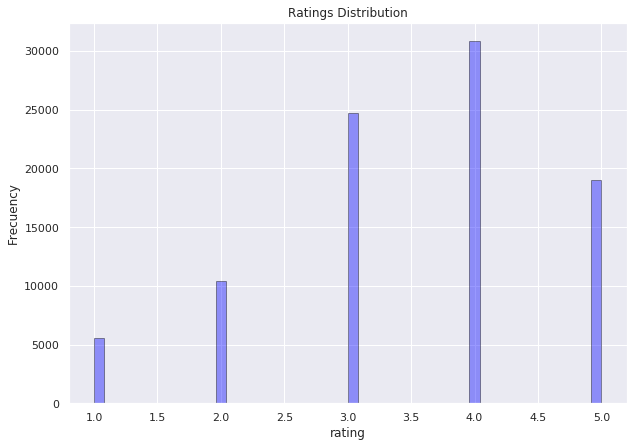

In [12]:
# seaborn histogram
sns.distplot(ratings['rating'], 
             hist=True, 
             kde=False, 
             color='blue',
             hist_kws={'edgecolor':'black'})

plt.title("Ratings Distribution")
plt.ylabel("Frecuency")
plt.show()

Since we are going to apply the mashine factorization algorithm for classification, we must convert the target variable (rating) into a binary variable. We will code as 1 those users who rated the film as good (rating greater than or equal to 4) and as 0 those who did not like it (rating less than 4)

In [13]:
ratings['rating_bin'] = (ratings.rating>=4).astype('float32')
ratings_test['rating_bin'] = (ratings_test.rating>=4).astype('float32')
ratings.head()

,userId,movieId,rating,timestamp,rating_bin
0,1,1,5,874965758,1.0
1,1,2,3,876893171,0.0
2,1,3,4,878542960,1.0
3,1,4,3,876893119,0.0
4,1,5,3,889751712,0.0


In [14]:
round(ratings.rating_bin.value_counts(normalize=True), 2)

1.0    0.55
0.0    0.45
Name: rating_bin, dtype: float64

As can be seen, the dataset is quite balanced. Let's verify that all users have sufficient ratings.

In [15]:
ratings.groupby('userId').count().rating.sort_values()

userId
202     10
441     10
685     10
34      10
36      10
      ... 
276    508
450    530
13     626
655    675
405    727
Name: rating, Length: 943, dtype: int64

In [16]:
ratings_test.groupby('userId').count().rating.sort_values()

userId
1      10
622    10
623    10
624    10
625    10
       ..
320    10
321    10
322    10
310    10
943    10
Name: rating, Length: 943, dtype: int64

All users have at least 10 movie ratings. Let's verify that all users and movies that are present in test are also present in train, otherwise we remove them from the test dataset.

In [17]:
print('Users of the test dataset are on the train dataset: {}'.format(ratings_test.userId.isin(ratings.userId).sum()==len(ratings_test.userId)))
print('Movie of the test dataset are on the train dataset: {}'.format(ratings_test.movieId.isin(ratings.movieId).sum()==len(ratings_test.movieId)))

Users of the test dataset are on the train dataset: True
Movie of the test dataset are on the train dataset: False


In [18]:
print('The movies that are in the test dataset and not in the train dataset are:')
ratings_test[ratings_test.movieId.isin(ratings.movieId)==False]

The movies that are in the test dataset and not in the train dataset are:


,userId,movieId,rating,timestamp,rating_bin
4049,405,1582,1,885548670,0.0
6749,675,1653,5,889489913,1.0


In [19]:
# We remove the observations
ratings_test = ratings_test.drop(index=ratings_test[ratings_test.movieId.isin(ratings.movieId)==False].index)
ratings_test.reset_index(drop=True,inplace=True)

In [20]:
print('Users of the test dataset are on the train dataset: {}'.format(ratings_test.userId.isin(ratings.userId).sum()==len(ratings_test.userId)))
print('Movie of the test dataset are on the train dataset: {}'.format(ratings_test.movieId.isin(ratings.movieId).sum()==len(ratings_test.movieId)))

Users of the test dataset are on the train dataset: True
Movie of the test dataset are on the train dataset: True


<a id='Preprocessing-data'></a>

### Preprocessing of the data

One-hot Encoding is a type of vector representation in which all of the elements in a vector are 0, except for one, which has 1 as its value, where 1 represents a boolean specifying a category of the element.  A similar technique to this one, also used to represent data, would be dummy variables in statistics. [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)

In our example we must transform with `OneHotEncoder` the variables **userId** and **movieId** to transform them into columns and represent them as binary variables. The `fit` y `transform` method is applied to the train dataset and the `transform` method is applied to the test dataset.


In [21]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=True)
enc.fit(ratings[['userId','movieId']])

X_train_OH = enc.transform(ratings[['userId','movieId']]).astype('float32')
Y_train_OH = ratings['rating_bin']

X_test_OH = enc.transform(ratings_test[['userId','movieId']]).astype('float32')
Y_test_OH = ratings_test['rating_bin']


In [22]:
print(X_train_OH[0,:])
print(X_test_OH[0,:])

  (0, 0)	1.0
  (0, 943)	1.0
  (0, 0)	1.0
  (0, 962)	1.0


In [23]:
print(Y_test_OH)

0       1.0
1       1.0
2       1.0
3       0.0
4       0.0
       ... 
9423    1.0
9424    1.0
9425    0.0
9426    1.0
9427    0.0
Name: rating_bin, Length: 9428, dtype: float32


In [24]:
columns = X_train_OH.shape[1]

print("Columns:{} ".format(X_train_OH.shape[1]))
print("Rows:{} ".format(X_train_OH.shape[0]))

Columns:2623 
Rows:90570 


<a id='Upload-training-data'></a>

### Upload training data

Since algorithms have particular input and output requirements, converting the dataset is also part of the process that a data scientist goes through prior to initiating training. In this particular case, the Amazon SageMaker implementation of Factorization Machines takes recordIO-wrapped protobuf, where the data we have today is a pickle-ized numpy array on disk.


In [25]:
# Función que permite guardar en formato protobuf en un bucket de S3
def writeDatasetToProtobuf(X, Y, bucket, prefix, key):
    buf = io.BytesIO()
    smac.write_spmatrix_to_sparse_tensor(buf, X, Y)
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket, obj)

In [26]:
%%time
train_data = writeDatasetToProtobuf(X_train_OH, Y_train_OH, bucket, train_prefix, train_key)    
test_data = writeDatasetToProtobuf(X_test_OH, Y_test_OH, bucket, test_prefix, test_key)    
  
print(train_data)
print(test_data)
print('Output: {}'.format(output_prefix))

s3://sagemaker-us-east-1-338408246139/builtin-notebooks/Recomendation-Machine/Explicit/train/train.protobuf
s3://sagemaker-us-east-1-338408246139/builtin-notebooks/Recomendation-Machine/Explicit/test/test.protobuf
Output: s3://sagemaker-us-east-1-338408246139/builtin-notebooks/Recomendation-Machine/Explicit/output
CPU times: user 12.6 s, sys: 229 ms, total: 12.8 s
Wall time: 13 s


<a id='Training-model'></a>
## Training the model
---

Now that we are done with all the setup that is needed, we are ready to train our Factorization Machine. To begin, let us create a ``sageMaker.estimator.Estimator`` object. This estimator will launch the training job.

<a id='Training-parameters'></a>
### Training parameters
There are two kinds of parameters that need to be set for training. The first one are the parameters for the training job. These include:

* **image_uri**: Container image for the algorithm
* **Training instance count**: This is the number of instances on which to run the training. When the number of instances is greater than one, then the Factorization Machine algorithm will run in distributed settings. 
* **Training instance type**: This indicates the type of machine on which to run the training. 
* **Volume size**: Size in GB of the EBS volume to use for storing input data during training. Must be large enough to store training data.
* **Max run time**: Timeout in seconds for training. After this amount of time Amazon SageMaker terminates the job regardless of its current status.
* **Output path**: This the s3 folder in which the training output is stored.

In [27]:
from sagemaker.image_uris import retrieve

training_image = retrieve(region=boto3.Session().region_name, framework="factorization-machines", version='latest')

Defaulting to the only supported framework/algorithm version: 1. Ignoring framework/algorithm version: latest.


In [28]:
fm = sagemaker.estimator.Estimator(
    training_image,
    role,
    instance_count=1,
    instance_type='ml.c4.xlarge',
    volume_size=30,
    max_run=86400,
    output_path=output_prefix,
    sagemaker_session=sess,
)

Apart from the above set of parameters, there are hyperparameters that are specific to the algorithm. These are:

* **feature_dim**: The dimension of the input feature space. This could be very high with sparse input.
* **num_factors**: The dimensionality of factorization. As mentioned initially, factorization machines find a lower dimensional representation of the interactions for all features. Making this value smaller provides a more parsimonious model, closer to a linear model, but may sacrifice information about interactions. Making it larger provides a higher-dimensional representation of feature interactions, but adds computational complexity and can lead to overfitting. In a practical application, time should be invested to tune this parameter to the appropriate value.
* **predictor_type**: The type of predictor. binary_classifier: For binary classification tasks. regressor: For regression tasks.
* **epochs**: The number of training epochs to run.
* **mini_batch_size**: The size of mini-batch used for training. This value can be tuned for relatively minor improvements in fit and speed, but selecting a reasonable value relative to the dataset is appropriate in most cases.

You can check all the available hyperparameters at [Factorization Machines Hyperparameters](https://docs.aws.amazon.com/sagemaker/latest/dg/fact-machines-hyperparameters.html).


In [29]:
fm.set_hyperparameters(
    feature_dim=columns,
    num_factors=64,
    predictor_type='binary_classifier',
    epochs=30,
    mini_batch_size=200
)

<a id='Input-data-specification'></a>
### Input data specification

Set the data type and channels used for training. We have to specify `train` and `test` channels.

In [30]:
data_channels = {
    "train": train_data,
    "test": test_data
}

<a id='Training-job'></a>
### Launch the Training job

Start training by calling the fit method in the estimator. This will launch a SageMaker Training job with the requested parameters and hyperparameters.

When it's done, run the next cell to see the training results.

In [31]:
%%time 

fm.fit(inputs=data_channels, logs=True)

2021-12-22 19:00:47 Starting - Starting the training job...
2021-12-22 19:00:52 Starting - Launching requested ML instancesProfilerReport-1640199647: InProgress
......
2021-12-22 19:02:16 Starting - Preparing the instances for training............
2021-12-22 19:04:17 Downloading - Downloading input data...
2021-12-22 19:04:46 Training - Training image download completed. Training in progress..Docker entrypoint called with argument(s): train
Running default environment configuration script
/opt/amazon/lib/python3.7/site-packages/jsonref.py:8: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Mapping, MutableMapping, Sequence
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:87: DeprecationWarning: invalid escape sequence \s
  """
/opt/amazon/lib/python3.7/site-packages/algorithm/network_builder.py:120: DeprecationWarning: invalid 

In [32]:
from IPython.display import display, display_markdown

job_desc = fm.latest_training_job.describe()

job_name = job_desc["TrainingJobName"]
job_arn = job_desc["TrainingJobArn"]
creation_time = job_desc["CreationTime"]
train_start_time = job_desc["TrainingStartTime"]
train_end_time = job_desc["TrainingEndTime"]
job_output = job_desc["ModelArtifacts"]["S3ModelArtifacts"]
train_time = job_desc["TrainingTimeInSeconds"]

desc_md = f"""# **Train Job**
| | |
|---|---|
| **Name** | {job_name} |
| **ARN**  | {job_arn} |
| **Creation Time** | {creation_time} |
| **Output** | {job_output} |
| **Training Start Time** | {train_start_time} |
| **Training End Time** | {train_end_time} |
| **Training Time** | {train_time} seconds |
| **Training Set Input** | {s3_train} |

## Hyperparameters
| | |
|---|---|
"""
for name, val in job_desc["HyperParameters"].items():
    desc_md += f"| **{name}** | {val} |\n"

desc_md += """
## Metrics
| | |
|---|---|
"""
for metric in job_desc["FinalMetricDataList"]:
    name, val = metric["MetricName"], metric["Value"]
    desc_md += f"| **{name}** | {val} |\n"

display_markdown(desc_md, raw=True)

# **Train Job**
| | |
|---|---|
| **Name** | factorization-machines-2021-12-22-19-00-47-575 |
| **ARN**  | arn:aws:sagemaker:us-east-1:338408246139:training-job/factorization-machines-2021-12-22-19-00-47-575 |
| **Creation Time** | 2021-12-22 19:00:47.805000+00:00 |
| **Output** | s3://sagemaker-us-east-1-338408246139/builtin-notebooks/Recomendation-Machine/Explicit/output/factorization-machines-2021-12-22-19-00-47-575/output/model.tar.gz |
| **Training Start Time** | 2021-12-22 19:04:05.210000+00:00 |
| **Training End Time** | 2021-12-22 19:05:45.133000+00:00 |
| **Training Time** | 100 seconds |
| **Training Set Input** | s3://sagemaker-us-east-1-338408246139/builtin-notebooks/Recomendation-Machine/Explicit/train/ |

## Hyperparameters
| | |
|---|---|
| **epochs** | 30 |
| **feature_dim** | 2623 |
| **mini_batch_size** | 200 |
| **num_factors** | 64 |
| **predictor_type** | binary_classifier |

## Metrics
| | |
|---|---|
| **train:progress** | 100.0 |
| **test:binary_f_beta** | 0.7624136805534363 |
| **train:binary_classification_accuracy:batch** | 0.7599999904632568 |
| **train:binary_f_beta:batch** | 0.8260869383811951 |
| **train:binary_classification_cross_entropy:epoch** | 0.5827834010124207 |
| **train:binary_f_beta** | 0.7644419074058533 |
| **train:binary_classification_cross_entropy** | 0.5827834010124207 |
| **train:binary_f_beta:epoch** | 0.7644419074058533 |
| **train:binary_classification_accuracy:epoch** | 0.7201876640319824 |
| **train:binary_classification_accuracy** | 0.7201876640319824 |
| **test:binary_classification_cross_entropy** | 0.6039596796035767 |
| **train:throughput** | 69653.3203125 |
| **test:binary_classification_accuracy** | 0.6934662461280823 |
| **train:binary_classification_cross_entropy:batch** | 0.5558118224143982 |


<a id='Batch-Inference'></a>

# Perform Batch Inference

***

We will use the trained model to perform a batch inference over a fixed set of observations. This can be useful when the trained model is being used as a Transformation step on a ETL pipeline, or when we need the results of the model to be precomputed (insted of getting live prediction requests on an endpoint).

In [33]:
def writeDatasetToProtobuf2(X, bucket, prefix, key, d_type, Y=None):
    buf = io.BytesIO()
    if d_type=="sparse":
        smac.write_spmatrix_to_sparse_tensor(buf, X, labels=Y)
    else:
        smac.write_numpy_to_dense_tensor(buf, X, labels=Y)
        
    buf.seek(0)
    obj = '{}/{}'.format(prefix, key)
    boto3.resource('s3').Bucket(bucket).Object(obj).upload_fileobj(buf)
    return 's3://{}/{}'.format(bucket,obj)

In [34]:
#upload inference data to S3
s3_batch_output = "s3://{}/{}/batch_output/".format(bucket, prefix)
prefix_batch = "{}/batch_inference".format(prefix)

s3_batch_input = writeDatasetToProtobuf2(X_test_OH, bucket, prefix_batch, test_key, "sparse")
print ("Batch inference data path: ",s3_batch_input)

Batch inference data path:  s3://sagemaker-us-east-1-338408246139/builtin-notebooks/Recomendation-Machine/Explicit/batch_inference/test.protobuf


In [35]:
fm_transformer = fm.transformer(
    instance_count=1,
    output_path=s3_batch_output,
    instance_type="ml.c4.xlarge",
    max_payload=1,
)

In [36]:
import uuid

In [37]:
%%time 

transform_job_name = f"{job_name}-{str(uuid.uuid4())[:8]}"
display(f"Launching Batch Transform Job {transform_job_name}")

s3_batch_inference = "s3://{}/{}/batch_inference/".format(bucket, prefix)

fm_transformer.transform(
    data=s3_batch_inference,
    split_type='RecordIO',
    content_type="application/x-recordio-protobuf",
    job_name=transform_job_name,
    wait=True,
    logs=False
)

'Launching Batch Transform Job factorization-machines-2021-12-22-19-00-47-575-0d303ad3'

.........................................................................!
CPU times: user 299 ms, sys: 31.2 ms, total: 330 ms
Wall time: 6min 7s


In [38]:
#Download predictions 
results_file_name = "inference_batch_output"
results_prefix_name = '{}/batch_output/test.protobuf.out'.format(prefix)
s3_client = boto3.client('s3')
s3_client.download_file(bucket, results_prefix_name, results_file_name)
with open(results_file_name) as f:
    results = f.readlines() 

In [39]:
pd.concat([pd.Series(results,name='predicted_label').apply(json.loads).apply(lambda x: x['predicted_label']),pd.Series(results,name='score').apply(json.loads).apply(lambda x: x['score']),ratings_test.rating,Y_test_OH],axis=1)

,predicted_label,score,rating,rating_bin
0,1.0,0.589505,4,1.0
1,1.0,0.577482,4,1.0
2,1.0,0.643375,4,1.0
3,1.0,0.648402,3,0.0
4,0.0,0.451894,2,0.0
...,...,...,...,...
9423,0.0,0.466676,4,1.0
9424,1.0,0.546960,4,1.0
9425,1.0,0.507472,1,0.0
9426,0.0,0.435448,4,1.0


In [40]:
# Evaluamos el accuracy del modelo
from sklearn.metrics import accuracy_score

print('The accuracy in dataset test is: {}'.format(accuracy_score(Y_test_OH, pd.Series(results,name='predicted_label').apply(json.loads).apply(lambda x: x['predicted_label'])).round(2)))

The accuracy in dataset test is: 0.69


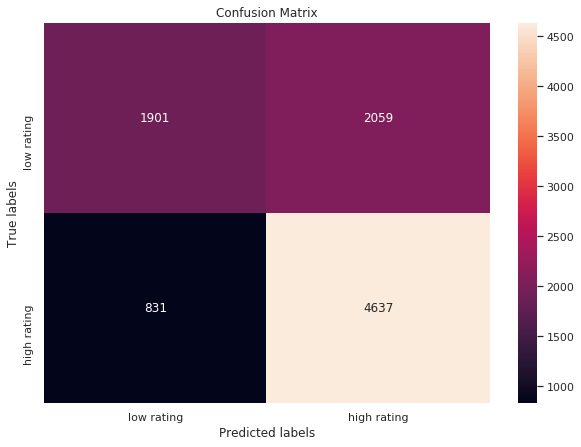

In [41]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test_OH, pd.Series(results, name='predicted_label').apply(json.loads).apply(lambda x: x['predicted_label']))

ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, fmt='g')

# labels, title and ticks
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['low rating', 'high rating'])
ax.yaxis.set_ticklabels(['low rating', 'high rating'])

<a id='Real-Time-Inference'></a>

# Perform Real-Time Inference

***

We now want to use the model to perform online inference. You can deploy the created model by using the `deploy` method in the `estimator`.

In [42]:
%%time
fm_predictor = fm.deploy(
    initial_instance_count=1,
    instance_type="ml.c4.xlarge",
    deserializer= JSONDeserializer()
)

--------!CPU times: user 139 ms, sys: 13.9 ms, total: 153 ms
Wall time: 4min 1s


<a id='Inferences'></a>
## Inferences

Factorization Machine is so often used with sparse data, performing inference requests with a CSV format (as is done in other algorithm examples) can be hugely inefficient. Instead of wasting space and time generating all those zeros, to fill the row with the correct dimensionality, JSON can be used more efficiently. 

In [43]:
endpoint_name = fm_predictor.endpoint_name
display(f"Endpoints name: {endpoint_name}")

'Endpoints name: factorization-machines-2021-12-22-19-12-12-457'

In [44]:
fm_predictor = sagemaker.predictor.Predictor(endpoint_name, 
                                             sagemaker_session=sagemaker.Session(), 
                                             #serializer=FMSerializer(),
                                             deserializer=JSONDeserializer()
                                            )

In [45]:
def serialize(data):
    js = {'instances': []}
    for row in data:
        js['instances'].append({'features': row.tolist()})
    return json.dumps(js)

In [46]:
cant_inferencias = 20
X_test_json = serialize(X_test_OH[:cant_inferencias,:].toarray())
result = fm_predictor.predict(X_test_json, initial_args={"ContentType": "application/json"})

#print(X_test_json)
pprint.pprint(result)

{'predictions': [{'predicted_label': 1.0, 'score': 0.5895045399665833},
                 {'predicted_label': 1.0, 'score': 0.5774816870689392},
                 {'predicted_label': 1.0, 'score': 0.6433746814727783},
                 {'predicted_label': 1.0, 'score': 0.6484015583992004},
                 {'predicted_label': 0.0, 'score': 0.4518936276435852},
                 {'predicted_label': 1.0, 'score': 0.5825338363647461},
                 {'predicted_label': 1.0, 'score': 0.6893323659896851},
                 {'predicted_label': 1.0, 'score': 0.7296139001846313},
                 {'predicted_label': 1.0, 'score': 0.6663004159927368},
                 {'predicted_label': 1.0, 'score': 0.6761026382446289},
                 {'predicted_label': 1.0, 'score': 0.5885559320449829},
                 {'predicted_label': 1.0, 'score': 0.8105983734130859},
                 {'predicted_label': 1.0, 'score': 0.7238032221794128},
                 {'predicted_label': 1.0, 'score': 0.50055980682

This type of JSON format to pass the inferences has certain limitations, since the complete rows of o's and 1's are passed to it, it usually fails when a number of rows is exceeded (depending on the dimension of the dataset). One of the options is to make the inferences by parts and join the results. Another way that was found to solve this problem is to make the inferences, taking advantage of the fact that each row only contains information in the positions where they present 1 and not the zeros. The following JSON format is also accepted and much more optimal when it comes to inferring.

In [47]:
def serialize(data, target):
    js = {'instances': []}
    shape = data.shape[1]
    x_test = pd.DataFrame()
    for row in data:
        userId_index = row.tocoo().col[0]
        movieId_index = row.tocoo().col[1]
        x_test = x_test.append(pd.DataFrame({'userId':[enc.categories_[0][userId_index]], 'movieId':[enc.categories_[1][movieId_index-len(enc.categories_[0])]]}))
        js['instances'].append({"data":{"features":{"keys": [int(userId_index), int(movieId_index)], "shape": [shape], "values": [1,1]}}})
    salida = pd.concat([x_test.reset_index(drop=True), pd.DataFrame({'rating':target.astype(int)}).reset_index(drop=True)], axis=1)
    return salida,json.dumps(js)

In [48]:
#cant_inferencias = X_test_OH.shape[0]
cant_inferencias = 100
X_test,X_test_json = serialize(X_test_OH[:cant_inferencias,:], Y_test_OH[:cant_inferencias])
result = fm_predictor.predict(X_test_json, initial_args={"ContentType": "application/json"})


In [49]:
pd.DataFrame.from_dict(result['predictions'])

,score,predicted_label
0,0.589505,1.0
1,0.577482,1.0
2,0.643375,1.0
3,0.648402,1.0
4,0.451894,0.0
...,...,...
95,0.632684,1.0
96,0.657884,1.0
97,0.739731,1.0
98,0.675430,1.0


In [50]:
n_predict = 3000
n_iter = X_test_OH.shape[0]//n_predict 

print(n_predict)
print(n_iter)

3000
3


In [51]:
%%time
salida_test = pd.DataFrame()

for i in range(n_iter+1):
    if i==n_iter:
        
        X_test,X_test_json = serialize(X_test_OH[i*n_predict:,:], Y_test_OH[i*n_predict:])
        result_i = fm_predictor.predict(X_test_json, initial_args={"ContentType": "application/json"})
        salida_i = pd.DataFrame.from_dict(result_i['predictions'])
        salida_i = pd.concat([X_test,salida_i],axis=1)
        salida_test = salida_test.append(salida_i)
    else:
        
        X_test,X_test_json = serialize(X_test_OH[i*n_predict:(i+1)*n_predict,:], Y_test_OH[i*n_predict:(i+1)*n_predict])
        result_i = fm_predictor.predict(X_test_json, initial_args={"ContentType": "application/json"})
        salida_i = pd.DataFrame.from_dict(result_i['predictions'])
        salida_i = pd.concat([X_test,salida_i],axis=1)
        salida_test = salida_test.append(salida_i)


salida_test.reset_index(drop=True, inplace=True)
desc_md = f"""# **Inferences**"""
display_markdown(desc_md, raw=True)
print(salida_test)

# **Inferences**

      userId  movieId  rating     score  predicted_label
0          1       20       1  0.589505              1.0
1          1       33       1  0.577482              1.0
2          1       61       1  0.643375              1.0
3          1      117       0  0.648402              1.0
4          1      155       0  0.451894              0.0
...      ...      ...     ...       ...              ...
9423     943      232       1  0.466676              0.0
9424     943      356       1  0.546960              1.0
9425     943      570       0  0.507472              1.0
9426     943      808       1  0.435448              0.0
9427     943     1067       0  0.580828              1.0

[9428 rows x 5 columns]
CPU times: user 10.2 s, sys: 24.9 ms, total: 10.2 s
Wall time: 10.7 s


In [52]:
salida_test.to_csv("prediccion_test.csv")

<a id='Recommend'></a>
## Recommend

Finally, we are going to generate a Recommend function that will allow us to make the top X recommendations of the movies that I have not rated yet for each userID.

In [53]:
def recommend(userId, data, enc, k=10):
    
    js = {'instances': []}
    shape = len(enc.categories_[0])+len(enc.categories_[1])
    recommend = pd.DataFrame()
    
    movie = data.movieId[data.userId==userId]
    movie_not = set(data.movieId.unique())-set(movie)
    userId_index = np.where(enc.categories_[0]==userId)[0][0]
    for m in movie_not:
        movie_index = np.where(enc.categories_[1]==m)[0][0]
        js['instances'].append({"data":{"features":{"keys":[int(userId_index),int(movie_index)], "shape": [shape], "values": [1,1]}}})
        
    result = fm_predictor.predict(json.dumps(js), initial_args={"ContentType": "application/json"})
    
    recommend = pd.DataFrame.from_dict(result['predictions'])
    recommend['userId'] = userId
    recommend['movieId'] = movie_not
    return recommend[['userId','movieId','score']].loc[recommend.predicted_label==1].sort_values(by='score',ascending=False).reset_index(drop=True).loc[:(k-1),:]
        

In [54]:
recommend = recommend(1, ratings, enc)
recommend

,userId,movieId,score
0,1,993,0.836662
1,1,1007,0.831354
2,1,1041,0.827010
3,1,1426,0.825527
4,1,1070,0.819956
5,1,1261,0.819297
6,1,1422,0.818360
7,1,955,0.815554
8,1,1370,0.813222
9,1,1117,0.809409


<a id='Clean'></a>
### Clean up


When we're done with the endpoint, we can just delete it and the backing instances will be released. Uncomment and run the following cell to delete the endpoint and model

In [55]:
fm_predictor.delete_endpoint()